# Kütüphanelerin Yüklenmesi 

In [14]:
import numpy as np # Dizi ve matris işlemleri için özelleşmiş bir kütüphanedir.
import matplotlib.pyplot as plt #Grafikleştirme işlemleri için kullanılan kütüphanedir.
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
#Eğitim öncesi görüntü ayarlarını yapmak için kullanılır.
#Görüntü artırma, ölçeklendirme gibi işlemler.

In [15]:
import glob, os#dosya işlemleri için kullanılan kütüphanelerdir.
import random 

# Verisetinin yüklenmesi

In [16]:
#Dosya yolu
base_path = r"C:\Users\Turan\Desktop\DerinOgrenme\TezCalismalari\veriseti\Garbage classification\garbage classification\Garbage classification"
#dosyadan okunan fotoğrafların yüklendiği değişken
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print(len(img_list))

2527


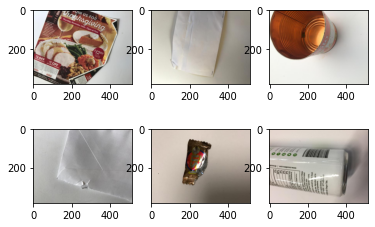

In [17]:
#Verisetinden örnek bir kaç görüntü
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

# Veri setinin modelin girişine hazırlanması ve bölünmesi 

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,#Ölçeklendirme, verilen değerle çarpılır.
    shear_range=0.1,#Kesme açısı
    zoom_range=0.1,#Rastgele yaklaştırma
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,#Girilen değeri rastgele yatay çevirme.
    vertical_flip=True,#Girilen değeri rastgele dikey çevirme.
    validation_split=0.1#Doğrulama için ayrılan val'ın oranı
)

test_datagen = ImageDataGenerator(
    rescale=1./255,#ölçeklendirme
    validation_split=0.1#Doğrulama için ayrılan val'ın oranı
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),#Fotoğrafın kaça kaç olacağı
    class_mode='categorical',#Sınıfların sırasını kontrol etmek için kullanılır
    subset='training',#Alt küme ayarlama validation/training
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),#Fotoğrafın kaça kaç olacağı
    # batch_size=50,#Veri yığınlarının boyutu.
    class_mode='categorical',
    subset='validation',#Alt küme ayarlama validation/training
    seed=0
)

#Etiketlerin gösterimi
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


## Inception mimarisinin yüklenmesi

In [19]:
from keras.applications.inception_v3 import InceptionV3 #Applications içerisinde hazır mimariler bulunmaktadır. 
#Burada Inception mimarisini çekilmiştir.

#Giriş görüntüsünün boyutu(300x300) ayarlandı ve daha önceden indirilen ağırlıklar giriş modeline yüklendi.
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))
base_model.load_weights(r'C:\Users\Turan\Desktop\DerinOgrenme\TezCalismalari\veriseti\inceptionv3\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
base_model.trainable = False

## Yeni model oluşturma

In [20]:
from keras.models import Sequential#Model oluşturmayı sağlar.
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
#Konvolüsyon,Flatten(Düzleştirme),Havuzlama(MAX),Dropout ve Normal katmanların kullanımını sağlar.

model = Sequential([#Model oluşturma
    base_model,#Giriş modeli (Functional)
    GlobalAveragePooling2D(),#Havuzlama Katmanı
    Dropout(0.15),
    Dense(1024, activation='relu'),#Tam bağlı katman
    Dense(6, activation='softmax')#Çıkış katmanı
])

## Modeli Derleme

In [21]:
from keras import optimizers, losses #Optimizasyon ve kayıp fonksiyonlarının kullanımını sağlar.

opt = optimizers.Adam(lr=0.0001)#Optimizasyon için Adam fonksiyonu seçildi ve learning rate 0.0001 olarak belirlendi.
model.compile(#Model derleme işlemleri. 
    loss="categorical_crossentropy",#Kayıp fonksiyonu
              optimizer=opt, #Optimizyon fonksiyonu
              metrics=['accuracy']) #Doğruluk ölçütü-değeri


In [22]:
model.summary() #model özeti

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 6150      
Total params: 23,907,110
Trainable params: 2,104,326
Non-trainable params: 21,802,784
_________________________________________________________________


In [23]:
batch_size = 32 #Bir seferde verilecek veri yığını boyutu
epochs = 100 #İterasyon sayısı

In [24]:
#bir iterasyonda verilecek train ve test verilerinin oranlanması
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

## Early Stopping ve Model Checkpoint

In [2]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


filepath = "model_inception_{epoch:02d}-{val_accuracy:.2f}.h5"#Kaydedilecek modelin adı
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)#Aşırı öğrenmeyi önlemek için kullanılır.
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#Modelin test verisi üzerinde başarısı her arttığında kaydetme işlemini yapar.
callbacks_list = [es, checkpoint1]#Eğitime verilmek için liste haline getirildi.

## Modelin eğitilmesi

In [26]:
history = model.fit_generator(
    generator=train_generator, #Eğitim verisi
    epochs=epochs, #iterasyon sayısı
    steps_per_epoch=steps_per_epoch, 
    validation_data=validation_generator,#Test verisi
    validation_steps=validation_steps,
    callbacks=callbacks_list#Early stopping ve model checkpoint değerleri
)

Epoch 1/100
71/71 [==============================] - 51s 626ms/step - loss: 1.2780 - accuracy: 0.5327 - val_loss: 0.5708 - val_accuracy: 0.8080

Epoch 00001: val_accuracy improved from -inf to 0.80804, saving model to model_inception_01-0.81.h5
Epoch 2/100
71/71 [==============================] - 53s 743ms/step - loss: 0.5814 - accuracy: 0.8070 - val_loss: 0.5115 - val_accuracy: 0.8259

Epoch 00002: val_accuracy improved from 0.80804 to 0.82589, saving model to model_inception_02-0.83.h5
Epoch 3/100
71/71 [==============================] - 48s 667ms/step - loss: 0.5071 - accuracy: 0.8287 - val_loss: 0.4269 - val_accuracy: 0.8438

Epoch 00003: val_accuracy improved from 0.82589 to 0.84375, saving model to model_inception_03-0.84.h5
Epoch 4/100
71/71 [==============================] - 51s 718ms/step - loss: 0.4357 - accuracy: 0.8521 - val_loss: 0.4324 - val_accuracy: 0.8571

Epoch 00004: val_accuracy improved from 0.84375 to 0.85714, saving model to model_inception_04-0.86.h5
Epoch 5/100


Epoch 00039: val_accuracy improved from 0.90625 to 0.91518, saving model to model_inception_39-0.92.h5
Epoch 40/100
71/71 [==============================] - 50s 705ms/step - loss: 0.0988 - accuracy: 0.9784 - val_loss: 0.3417 - val_accuracy: 0.8839

Epoch 00040: val_accuracy did not improve from 0.91518
Epoch 41/100
71/71 [==============================] - 53s 747ms/step - loss: 0.1137 - accuracy: 0.9623 - val_loss: 0.3622 - val_accuracy: 0.8839

Epoch 00041: val_accuracy did not improve from 0.91518
Epoch 42/100
71/71 [==============================] - 53s 740ms/step - loss: 0.1153 - accuracy: 0.9677 - val_loss: 0.3308 - val_accuracy: 0.9107

Epoch 00042: val_accuracy did not improve from 0.91518
Epoch 43/100
71/71 [==============================] - 52s 735ms/step - loss: 0.1143 - accuracy: 0.9680 - val_loss: 0.3996 - val_accuracy: 0.8616

Epoch 00043: val_accuracy did not improve from 0.91518
Epoch 44/100
71/71 [==============================] - 52s 736ms/step - loss: 0.1297 - accura

## Sonuç skoru

In [28]:
score = model.evaluate(validation_generator,batch_size=32)#Modeli test verisi ile dener.
score
print('Score Accuracy : {:.2f}%'.format(score[1]*100))#Sonucu yüzdeye uyarlar.

8/8 [==============================] - 4s 583ms/step - loss: 0.3967 - accuracy: 0.8964
Score Accuracy : 89.64%


## Sonuçların görselleştirilmesi

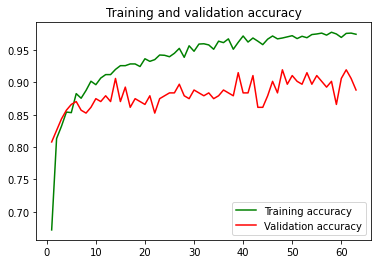

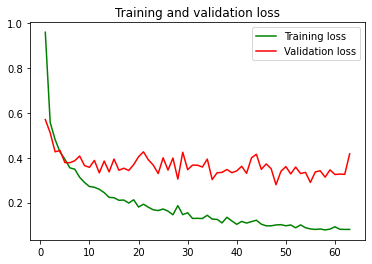

In [30]:
#Eğitim sürecinin görselleştirilmesi

import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'g', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()